In [15]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
np.random.seed(1)
tf.random.set_seed(1)
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.11.0


**Author:** Alva Rani James, PhD, **Year:** 2023

This excercise covers
 - Anomaly Detection
 - LSTM Autoencoders
 - S&P 500 Index Data
 - LSTM Autoencoder in Tensorflow
-  Finding Anomalies

## What is Anomaly detection?

Anomaly detection is the process of identifying uncommon events or data points. 
- It has a variety of applications, such as detecting fraudulent activity in banking, detecting tumors in medical imaging, and identifying errors in written text
Methods:  
- A lot of supervised and unsupervised approaches 
   - Some of the approaches include
    - One-class SVMs, Bayesian Networks, Cluster analysis, and (of course) Neural Networks.

## Autoencoders

In short

It is an unsupervised learning technique, trained using supervised learning methods
During training, the autoencoder adjusts its weights and biases to minimize the reconstruction error by using techniques such as backpropagation and gradient descent
By minimizing the reconstruction error, the autoencoder learns to encode and decode the input data effectively:
  - Creating a compressed representation of the input data 
  - This encoding should capture the most important features of the data and enable the model to generate an output that is similar to the original input. 
  - In other words, the autoencoder is trained to reconstruct the input data from a compressed representation of it.
   - The applications are image compression, anomaly detection, and feature learning

For detail read: https://en.wikipedia.org/wiki/Autoencoder

## Import data

Download the data from this link: https://www.kaggle.com/datasets/pdquant/sp500-daily-19862018

The data contains only two columns/features - 
- the date and the closing price, between 1986 to 2018

In [ ]:
!wget https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76 >spx.csv

In [3]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


We can use the Long Short-Term Memory, or LSTM, auto encoders for the purpose, for details:https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/
They support sequence of input data and can learn complex dynamics within input sequences

## Visualize the time series

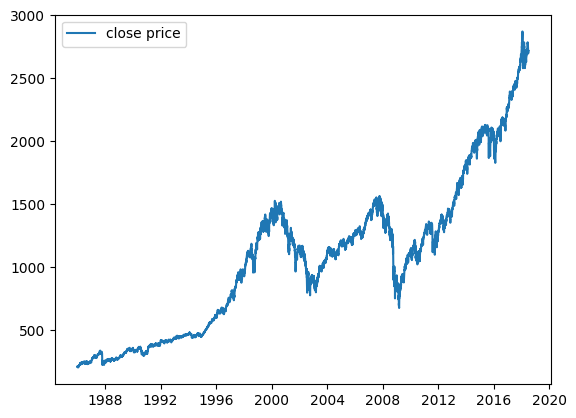

In [4]:

plt.plot(df, label='close price')
plt.legend();

- Over the past years, there has been a promising trend that may present a good investment opportunity. 
 you're interested, it might be worth considering investing in this trend. However, it's important to determine the best time to buy or sell. 
    Additionally, it's valuable to identify anomalies or sudden changes as early as possible.

## Data Preprocessing

Steps:
   1. use 95% of data to train the model
   2. Rescale the data using the train data and test data
   3. split the data into subsequences ( sequences with 30 days worth of historical data:

In [5]:
# Use the 95% of the data to train our model
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

(7782, 1) (410, 1)


/tmp/ipykernel_76082/1142505744.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
/tmp/ipykernel_76082/1142505744.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [7]:
def create_seq(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_seq(
  train[['close']],
  train.close,
  TIME_STEPS
)
X_test, y_test = create_seq(
  test[['close']],
  test.close,
  TIME_STEPS
)
print(X_train.shape)

(7752, 30, 1)


## Bulid the model

Model should take a sequence as input and outputs a sequence of the same shape.
Here’s how to build such a simple model in Keras

In [9]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

2023-03-13 15:04:37.359761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 15:04:37.359870: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 15:04:37.359928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ctg-vm): /proc/driver/nvidia/version does not exist
2023-03-13 15:04:37.366328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Definition: 
 - The RepeatVector layer duplicates the input n times, 
    - while setting return_sequences=True in the LSTM layer makes it return a sequence. 
    - The TimeDistributed layer then creates a - vector with a length equal to the number of outputs from the preceding layer. -  - By combining these layers, 
you can create an LSTM Autoencoder that is ready for training. 
- The training process is similar to that of a regular LSTM model.
- Finally, we added a TimeDistributed(Dense(X_train.shape[2])) layer at the end of the network to obtain the output, 
   - where X_train.shape[2] represents the number of features in the input data

## Train the model

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 24s 81ms/step - loss: 0.1845 - val_loss: 0.1934
Epoch 2/10
218/218 [==============================] - 15s 68ms/step - loss: 0.1077 - val_loss: 0.1600
Epoch 3/10
218/218 [==============================] - 15s 70ms/step - loss: 0.1030 - val_loss: 0.1759
Epoch 4/10
218/218 [==============================] - 14s 66ms/step - loss: 0.0984 - val_loss: 0.1816
Epoch 5/10
218/218 [==============================] - 15s 68ms/step - loss: 0.1040 - val_loss: 0.3152
Epoch 6/10
218/218 [==============================] - 15s 70ms/step - loss: 0.1100 - val_loss: 0.2554
Epoch 7/10
218/218 [==============================] - 15s 69ms/step - loss: 0.0926 - val_loss: 0.3543
Epoch 8/10
218/218 [==============================] - 16s 72ms/step - loss: 0.1206 - val_loss: 0.2626
Epoch 9/10
218/218 [==============================] - 16s 74ms/step - loss: 0.1101 - val_loss: 0.1712
Epoch 10/10
218/218 [==============================] - 15s 70ms/step - loss: 0.104

## Evaluation

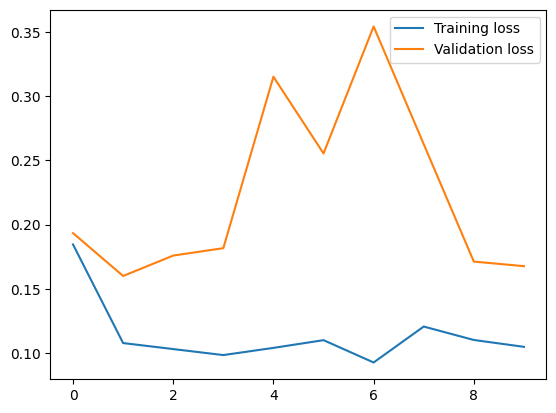

In [11]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [12]:
model.evaluate(X_test, y_test)


12/12 [==============================] - 0s 28ms/step - loss: 0.6693


0.6693000197410583

The output indicates that the evaluation process was carried out on 12 batches, and the average loss on the test set was 0.6693000197410583
 
- The value 0.6693000197410583 printed after the batch-level output is the final loss value returned by the evaluate function
  - which implies that the model is performing well in terms of detecting anomalies in the test data. A lower loss value indicates better performance.

## Determine anomalities

In [13]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 [==============================] - 8s 27ms/step


/home/ctg/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


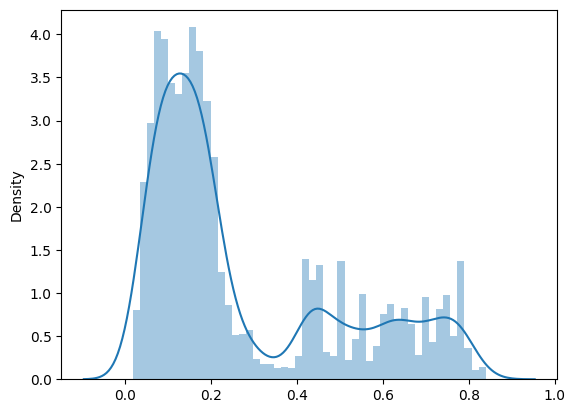

In [16]:
sns.distplot(train_mae_loss, bins=50, kde=True);


Pick a threshold of 0.75, 
as not much of the loss is larger than that. When the error is larger than that, we’ll declare that example an anomaly:

In [18]:
THRESHOLD = 0.75
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 1s 34ms/step


In [19]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

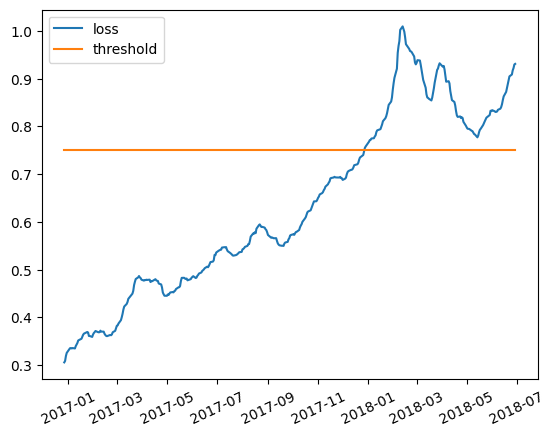

In [20]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();
     

It seems that we are effectively applying a threshold to filter out extreme values. 
- Let's use these filtered values to create a new DataFrame.

In [21]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-12-28,0.755103,0.75,True,3.179181
2017-12-29,0.758137,0.75,True,3.153016
2018-01-02,0.767957,0.75,True,3.194714
2018-01-03,0.771427,0.75,True,3.227115
2018-01-04,0.771827,0.75,True,3.247644


## Plot the final results

In [23]:
anomalies_close = anomalies[["close"]].values.flatten()
anomalies_close = anomalies_close.reshape(-1, 1) # Reshape to a 2D array with one column
anomalies_close = scaler.inverse_transform(anomalies_close)

/home/ctg/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


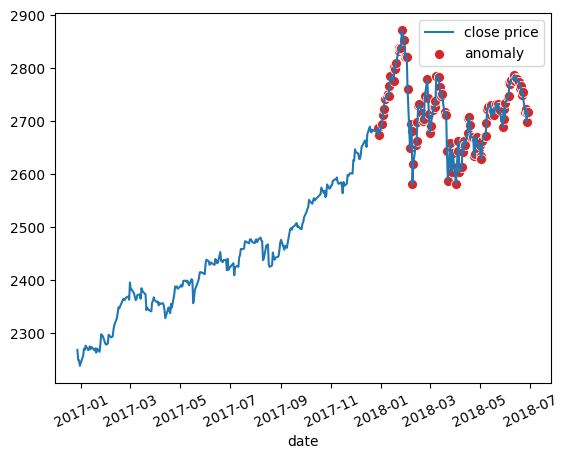

In [24]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:][["close"]]), 
  label='close price'
);
# convert it to a 1D array for the plot
anomalies_close = anomalies_close.flatten()

sns.scatterplot(
  anomalies.index,
  anomalies_close,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();
     

Interpretation:
It is important to carefully examine the chart. 
- The anomalies, represented by the red dots, seem to be present mainly in areas where there are sudden changes in the closing price

## Reference


 1 https://www.tensorflow.org/tutorials/structured_data/time_series

 2 https://colah.github.io/posts/2015-08-Understanding-LSTMs/  
 3 https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
 
 4 https://www.kaggle.com/pdquant/sp500-daily-19862018